In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
import tabulate
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
from app.models import Classifier
from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from sklearn.linear_model import LogisticRegression

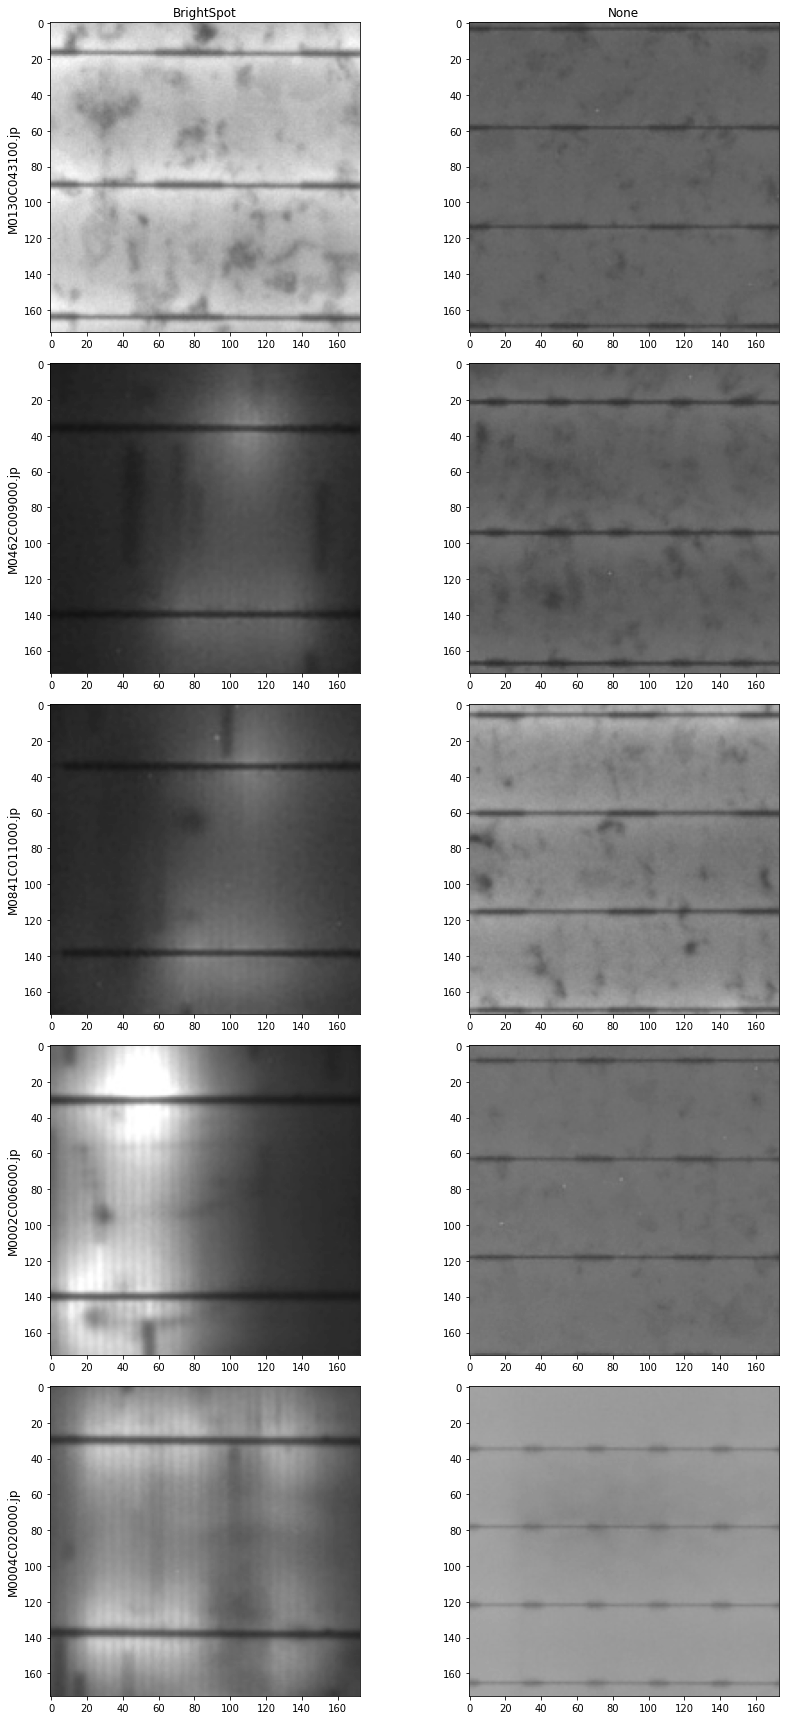

In [4]:
num_samples = 500
iml = ImageLoader()
defect_categories = iml.defect_classes
defect_class='BrightSpot'
not_defect_class = [x for x in defect_categories if x != defect_class]

defects = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=defect_class) << num_samples))
all_others = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=not_defect_class) << num_samples))
clean = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << num_samples))

single_defect = defects - all_others
single_defect.category = 'BrightSpot'
clean.category = 'None'

_ = Show(num_images=5, seed=2145) << (single_defect, clean)

In [5]:
# Get the oriented images
start = time.perf_counter()
oriented_defect = Orient(num_jobs=20) << single_defect
oriented_clean = Orient(num_jobs=20) << clean
oriented_all_defects = Orient(num_jobs=20) << defects
oriented_all_others = Orient(num_jobs=20) << all_others
print(time.perf_counter() - start)
#_ = Show(num_images=5) << oriented_defect + oriented_clean

106.04386154198437


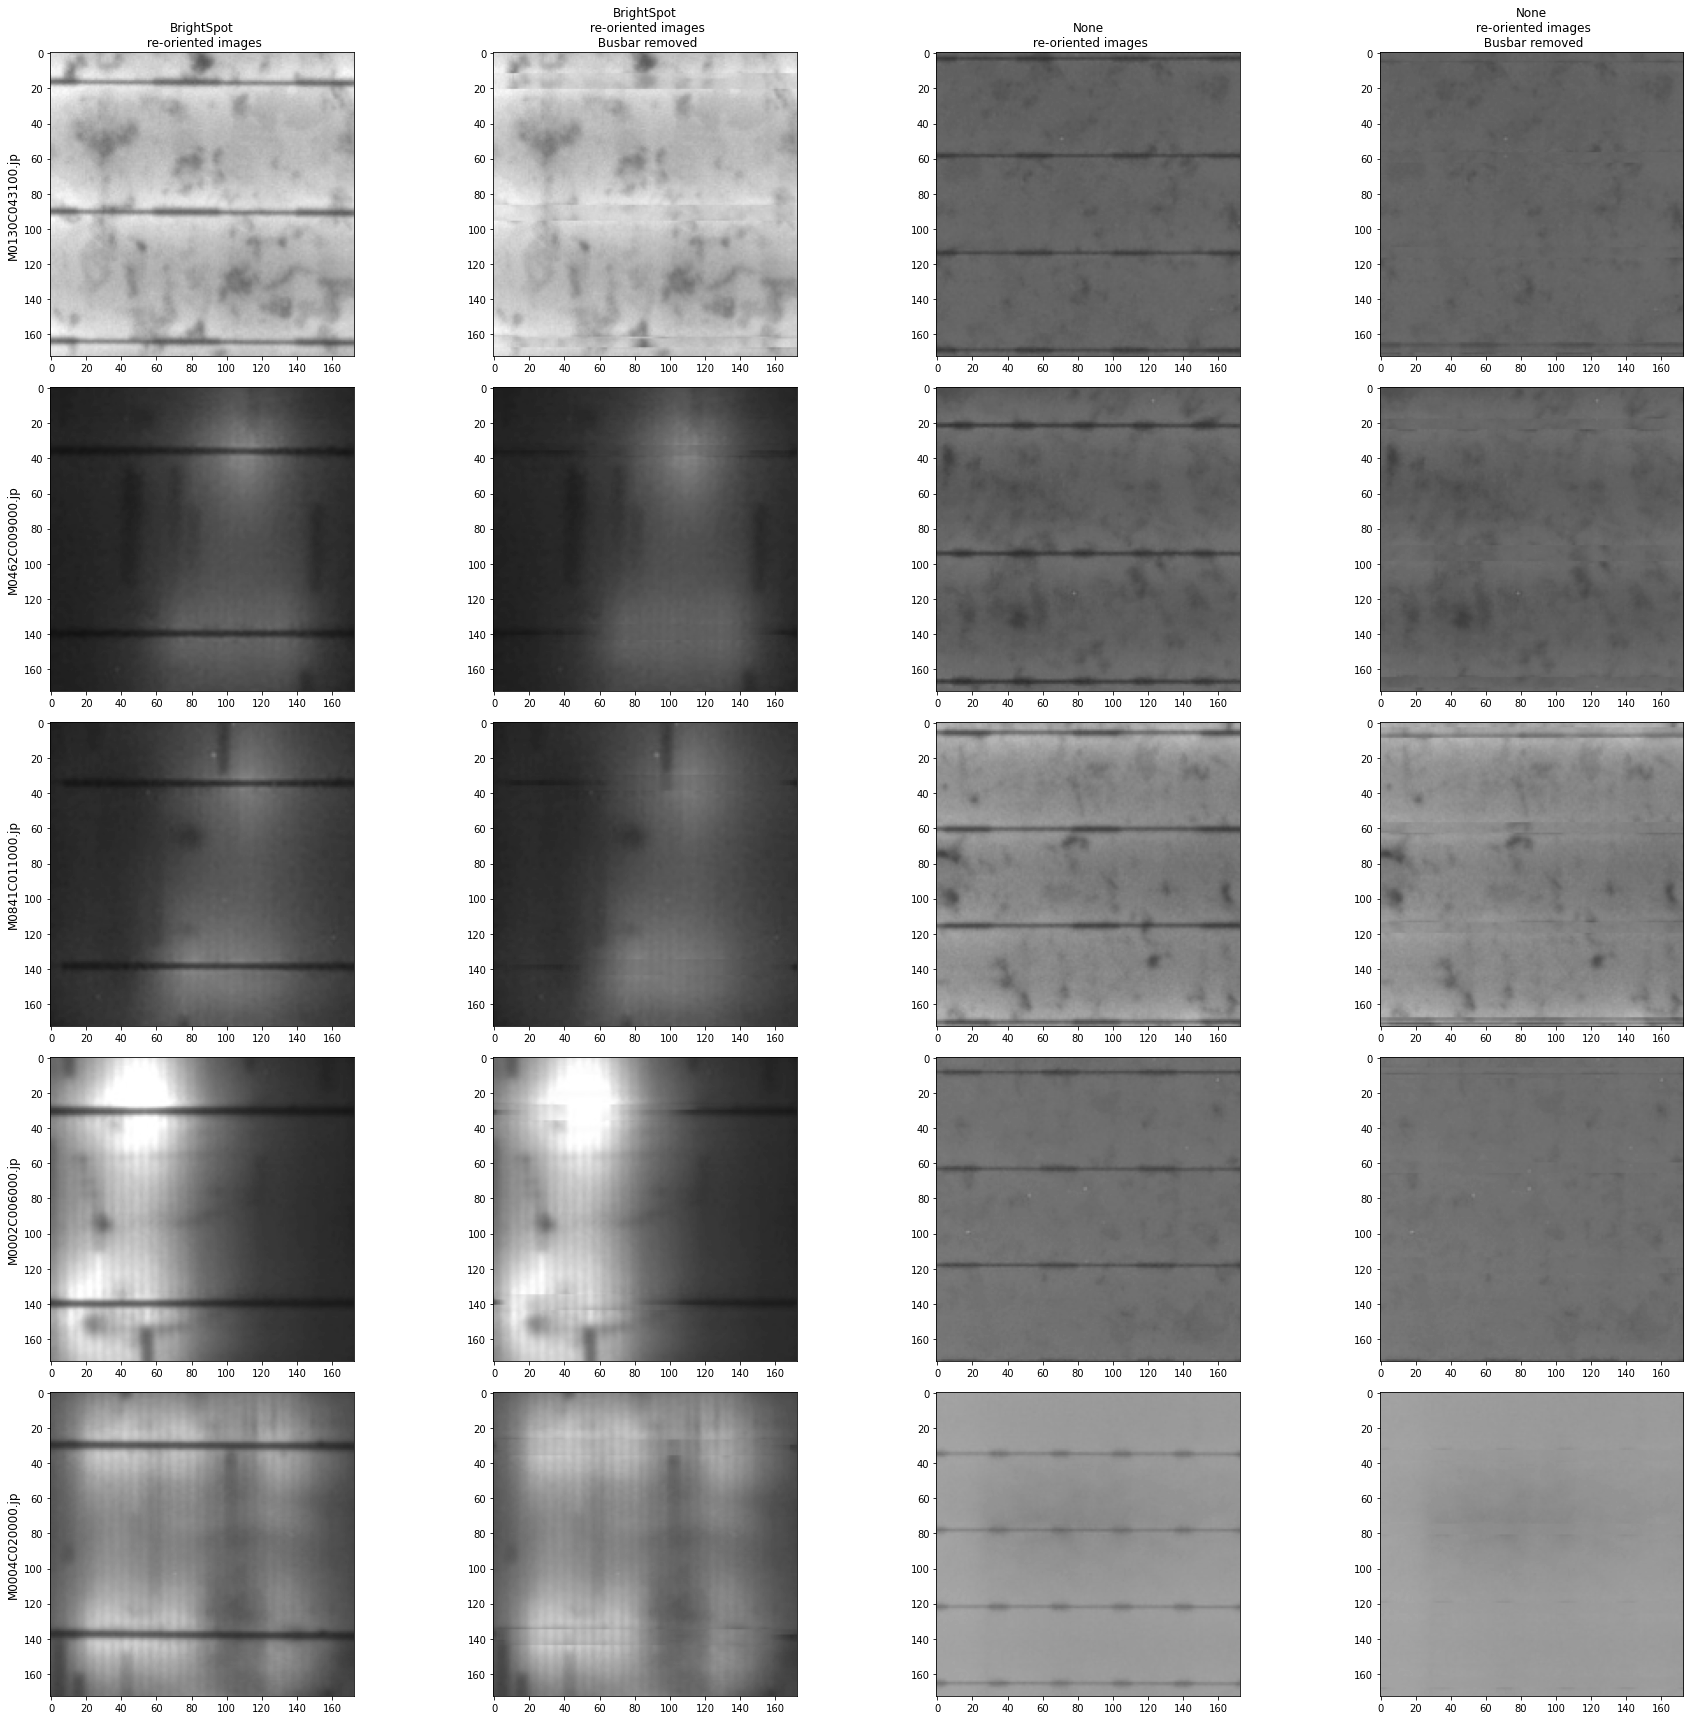

In [6]:
# Remove the BusBars
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean
nobus_all_defects = RemoveBusBars() << oriented_all_defects
nobus_all_others = RemoveBusBars() << oriented_all_others
_ = Show(num_images=5, seed=2145) << nobus_defect + nobus_clean

In [ ]:
# Gaussian Blur
defect_blur = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=5, std=8) << (Exposure('mean_norm') << oriented_defect))
clean_blur = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=5, std=8) << (Exposure('mean_norm') << oriented_clean))
defect_all_blur = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=5, std=8) << (Exposure('mean_norm') << oriented_all_defects))
all_others_blur = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=5, std=8) << (Exposure('mean_norm') << oriented_all_others))

# Show defective and clean images
_ = Show(num_images=5, seed=2145) << nobus_defect + defect_blur + nobus_clean + clean_blur

In [ ]:
# Do a Fourier Transform
fourier_defect = (FFT(dim=2) << defect_blur) 
fourier_clean = (FFT(dim=2) << clean_blur)
fourier_all_defects = (FFT(dim=2) << defect_all_blur)
fourier_all_others = (FFT(dim=2) << all_others_blur)
_ = Show(num_images=5, seed=2145) << fourier_defect + fourier_clean

### Start Modeling:

In [ ]:
scores = []
titles = []

# Base model on raw data - single defect vs. clean
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(single_defect, clean, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

scores.append(score)
titles.append('Base model single defect vs. clean')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# Base model on raw data - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects, all_others, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

scores.append(score)
titles.append('Base model all images with defect vs. rest of images')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# Base model on oriented and busbar images - single defect vs. clean
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defect_blur[-1], clean_blur[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)


scores.append(score)
titles.append('Base model single defect vs. clean /(oriented and busbars removed/)')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# Base model on oriented and busbar images - defect vs. all others
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defect_all_blur[-1], all_others_blur[-1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

scores.append(score)
titles.append('Base model all images with defect vs. rest of images /(oriented and busbars removed/)')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# Base model after gaussian blur and fourier transform - single defect vs. clean
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(fourier_defect[1], fourier_clean[1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

scores.append(score)
titles.append('Base model single defect vs. clean /(Gaussian Blur + Fourier/)')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
# Base model after gaussian blur and fourier transform - defect vs. all others

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(fourier_all_defects[1], fourier_all_others[1], LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(score)

scores.append(score)
titles.append('Base model all images with defect vs. rest of images /(Gaussian Blur + Fourier/)')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(scores))
y = np.array(scores)
plt.xticks(x, titles, rotation=90)
plt.plot(x, y, '-')
plt.show()

### Using model_features.py

In [36]:
from app.model_features import brightspots, get_samples
brightspot, not_brightspot = get_samples(defect_class, num_samples, complimentary=False)

In [ ]:
# Convert the data to the required format for grid interruption
brightspot_ = brightspots(brightspot, num_jobs=20)
not_brightspot_ = brightspots(not_brightspot, num_jobs=20)

In [ ]:
_ = Show(num_images=20, seed=seed) << (brightspot, brightspot_) + (not_brightspot, not_brightspot_)

In [ ]:
_ = Show(num_images=20, seed=seed) << (brightspot, brightspot_) + (not_brightspot, not_brightspot_)